In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions
using LinearAlgebra
using Test

using ForwardDiff
# using ReverseDiff
# using FiniteDifferences

using Revise
using EuclidianNormalizingFlows

┌ Info: Precompiling EuclidianNormalizingFlows [eb90128f-7c94-4cd6-9130-4bb7c9abac9d]
└ @ Base loading.jl:1423


In [2]:
# Compare transformation results & gradients using Finite Differences and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 20,
        ndims = 10,
        nparams = 10,
        nsmpls = 100,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions

        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 5), ndims, nsmpls)
        
        try 
            
            trafo_frwd = TrainableRQSpline(w,h,d)
            trafo_bcwd = TrainableRQSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            for j in 1:size(x, 2)
                xrun = x[:,j]
                
#                 autodiff_jac = FiniteDifferences.jacobian(algo, xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )[1]
                autodiff_jac = ForwardDiff.jacobian(xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )
                @test log(abs(det(autodiff_jac))) ≈ jac_frwd[1,j]
                @test log(abs(det(autodiff_jac))) ≈ -jac_bcwd[1, j]
            end

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(par,h,d), x), w)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(par,h,d), x), w)
            @test a_run ≈ gradvals.widths

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,par,d), x), h)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,par,d), x), h)
            @test a_run ≈ gradvals.heights

#             a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,h,par), x), d)[1]
            a_run = ForwardDiff.gradient(par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(TrainableRQSpline(w,h,par), x), d)
            @test a_run ≈ gradvals.derivatives
            
            println("Test no. $i successfull!")
        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

Test no. 1 successfull!
Test no. 2 successfull!
Test no. 3 successfull!
Test no. 4 successfull!
Test no. 5 successfull!
Test no. 6 successfull!
Test no. 7 successfull!
Test no. 8 successfull!
Test no. 9 successfull!
Test no. 10 successfull!
Test no. 11 successfull!
Test no. 12 successfull!
Test no. 13 successfull!
Test no. 14 successfull!
Test no. 15 successfull!
Test no. 16 successfull!
Test no. 17 successfull!
Test no. 18 successfull!
Test no. 19 successfull!
Test no. 20 successfull!


# 2D fit: 

In [18]:
nparams = 20
nsmpls = 6000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = TrainableRQSpline(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [19]:
@test x ≈ TrainableRQSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(TrainableRQSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (TrainableRQSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((TrainableRQSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [-0.717908493907354 1.214936944393101 … -0.07701264606019159 -0.10772321342056827; 1.11316501401001 -1.8495656323946295 … 0.7714570812107483 -1.127500658127465] ≈ [-0.717908493907354 1.214936944393101 … -0.07701264606019159 -0.10772321342056827; 1.11316501401001 -1.8495656323946295 … 0.7714570812107483 -1.127500658127465]

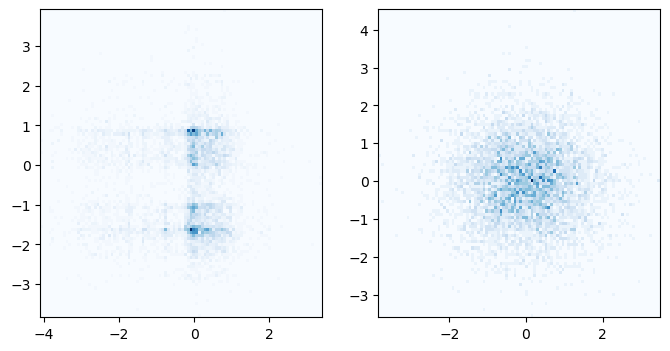

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.85471045271063, -3.7811360804436744, -3.7075617081767187, -3.633987335909763, -3.5604129636428072, -3.4868385913758515, -3.4132642191088958, -3.33968984684194, -3.2661154745749843, -3.1925411023080286  …  2.8405574235823416, 2.9141317958492974, 2.987706168116253, 3.061280540383209, 3.1348549126501646, 3.2084292849171203, 3.282003657184076, 3.355578029451032, 3.4291524017179875, 3.5027267739849437], [-3.6011321693983036, -3.5197283850126095, -3.4383246006269155, -3.356920816241221, -3.275517031855527, -3.194113247469833, -3.1127094630841388, -3.0313056786984447, -2.9499018943127506, -2.868498109927056  …  3.8066122096998645, 3.8880159940855585, 3.9694197784712526, 4.050823562856946, 4.13222734724264, 4.213631131628334, 4.295034916014028, 4.3764387003997225, 4.457842484785418, 4.539246269171112], PyObject <matplotlib.collections.QuadMesh object at 0x7fdf70228cd0>)

In [20]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [21]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  TrainableRQSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = TrainableRQSpline([0.8198732202980731 0.8198732202980731 … 1.1394446204097954 1.1394446204097954; 0.9172774578776671 0.9172774578776671 … 1.0796824074218732 1.0796824074218732], [1.3343550661197556 1.3343550661197556 … 0.8920169095946661 0.8920169095946661; 1.0377179315191394 1.0377179315191394 … 1.0460798841853345 1.0460798841853345], [1.0 0.8600014629482517 … 0.4998808330822273 1.0; 1.0 0.5264197889571698 … 1.0793524276784159 1.0]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [7.88166 7.88166 … 11.4006 11.4006; 9.22927 9.22927 … 8.66321 8.66321]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.595364 0.595364 … 0.316338 0.316338; 0.488931 0.488931 … 0.481329 0.481329]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [1.19209e-7 0.000195846 … 5.03264e-5 1.19209e-7; 1.19209e-7 5.16591e-6 … 0.000236952 1.19209e-7])), negll_history = [3.370036559402039, 3.070077823199358, 3.23584847449758, 2.905024189896594, 2.656742053547322, 2.707956378962

In [22]:
yhat = r.result(x)

2×6000 Matrix{Float64}:
 -0.727287   1.93853   0.10127  0.742022  …  1.27543   -0.270069  -0.343011
  1.61198   -1.22613  -1.89697  0.263376     0.524721   0.945685  -0.248355

In [23]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.006722951778101305; -0.011130116216749938;;]
std(yhat, dims = 2) = [0.9988696850051056; 0.9897899068074298;;]


2×1 Matrix{Float64}:
 0.9988696850051056
 0.9897899068074298

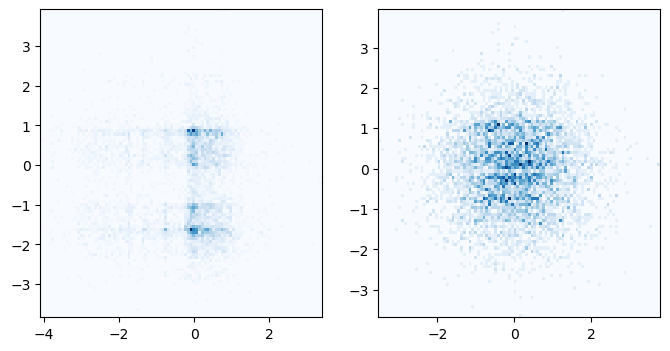

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.531759959403955, -3.4585368041805107, -3.3853136489570663, -3.312090493733622, -3.2388673385101776, -3.1656441832867332, -3.092421028063289, -3.0191978728398445, -2.9459747176164, -2.872751562392956  …  3.1315471659294825, 3.204770321152927, 3.277993476376371, 3.3512166315998155, 3.42443978682326, 3.497662942046705, 3.5708860972701495, 3.644109252493594, 3.717332407717038, 3.790555562940483], [-3.6835252472754094, -3.607212346996426, -3.530899446717442, -3.4545865464384584, -3.3782736461594745, -3.301960745880491, -3.2256478456015074, -3.1493349453225234, -3.07302204504354, -2.996709144764556  …  3.260948678112107, 3.3372615783910913, 3.413574478670075, 3.4898873789490583, 3.566200279228042, 3.6425131795070262, 3.7188260797860098, 3.7951389800649933, 3.871451880343977, 3.9477647806229603], PyObject <matplotlib.collections.QuadMesh object at 0x7fdf6fe080d0>)

In [24]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

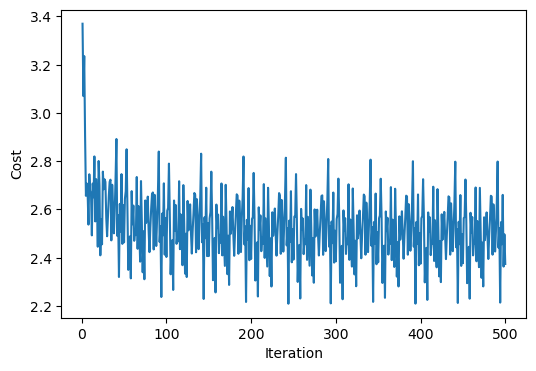

PyObject Text(0.5, 24.0, 'Iteration')

In [25]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [26]:
nparams = 20 # 1180 parameters in total
nsmpls = 6000
ndims = 200
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [27]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    TrainableRQSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

200×6000 Matrix{Float64}:
  1.24876    -0.642141    -0.917793    …  -0.396701   -1.28803    -2.14963
 -1.67938    -0.0488206   -0.442966       -1.68753    -1.73943    -1.74975
  1.55187     1.19455      1.16273         0.903751    0.949347   -0.108823
  0.0343658  -1.58227     -0.0908021      -0.683157    0.0422216  -1.93188
  0.985373    1.00594     -1.30006         0.103781    0.0300559   0.971512
  3.51689     1.47436      1.62762     …   1.166       2.14905     0.953747
  0.836871    2.51446      2.90674         2.53423    -0.679748    2.35236
  0.829533   -2.1612      -1.78651        -0.304189   -0.484195   -1.73651
 -0.71515    -0.480835    -0.514998       -0.872726    0.719486   -0.50214
  1.08279    -1.69997     -1.57005         0.156612   -2.08412    -1.4156
 -1.97846     1.49781     -2.7621      …  -1.15643    -1.15958     2.03237
 -0.289422   -0.00225047   0.00662369      0.783225   -0.264107   -0.4033
 -0.422814   -1.77875     -0.0567779       0.239831    1.31892     0.2956

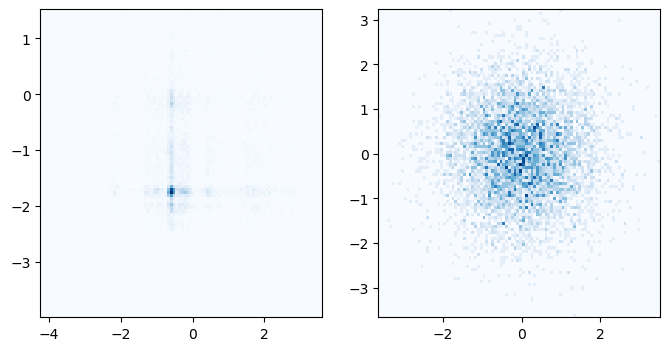

In [28]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [29]:
initial_trafo = 
    TrainableRQSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

@time r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

 15.470979 seconds (396.81 M allocations: 29.229 GiB, 35.56% gc time)


In [30]:
yhat = r.result(x);

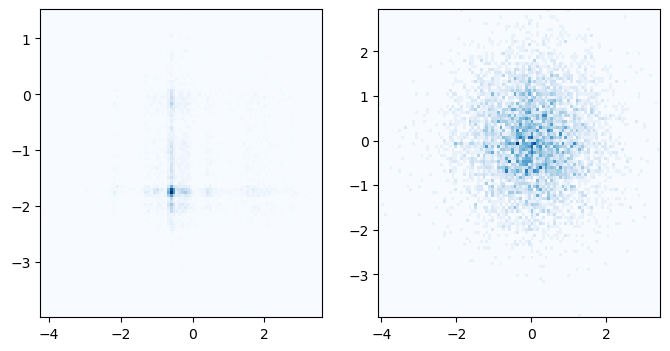

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.082203808610849, -4.006975545743738, -3.9317472828766262, -3.856519020009515, -3.7812907571424037, -3.706062494275292, -3.6308342314081807, -3.5556059685410695, -3.4803777056739578, -3.4051494428068465  …  2.76356811229629, 2.838796375163401, 2.9140246380305124, 2.9892529008976236, 3.064481163764735, 3.139709426631846, 3.2149376894989583, 3.2901659523660696, 3.365394215233181, 3.440622478100292], [-3.9647219218102596, -3.895607549493103, -3.826493177175947, -3.7573788048587904, -3.688264432541634, -3.6191500602244773, -3.550035687907321, -3.4809213155901646, -3.411806943273008, -3.342692570955852  …  2.3246859590509756, 2.393800331368132, 2.4629147036852888, 2.5320290760024453, 2.601143448319602, 2.6702578206367575, 2.739372192953914, 2.8084865652710707, 2.877600937588227, 2.9467153099053833], PyObject <matplotlib.collections.QuadMesh object at 0x7fdf70b1e490>)

In [31]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

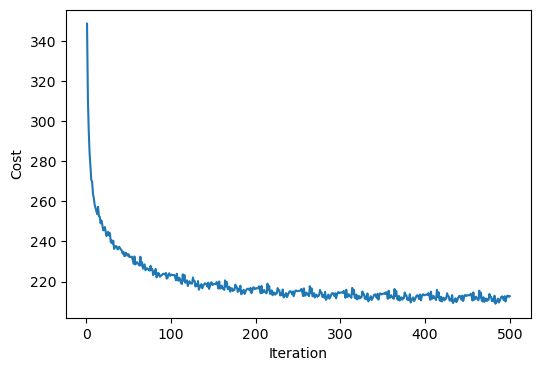

PyObject Text(0.5, 24.0, 'Iteration')

In [32]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# Coupling Test (debugging): 

In [34]:
nparams = 10
nsmpls = 6000
ndims = 2
K = nparams

y = rand(Normal(0, 1), ndims, nsmpls)

n_nn = (3*K-1)*1

dist = Uniform(-1, 1)

trafo_truth = RQSplineCoupling(ones(n_nn, 1), ones(n_nn))

# EuclidianNormalizingFlows.forward(trafo_truth, y)

(::RQSplineCoupling) (generic function with 1 method)